In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import pandas as pd
import cv2
import glob
import traceback
import xml.etree.ElementTree as ET
import albumentations as A

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV3Large
from sklearn.model_selection import train_test_split

import PIL
from PIL import Image 
from PIL.ImageDraw import Draw

2.19.0


In [14]:
def xml_to_csv(path):
    """
    Convert XML files to CSV with multiple classes
    Args:
        path: Path to the folder containing XML files
    Returns:
        Pandas DataFrame with columns ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    """
    xml_list = []
    
    # Get all XML files in the directory
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        
        # Get image size
        width = int(root.find('size/width').text)
        height = int(root.find('size/height').text)
        filename = root.find('filename').text

        # Check for objects
        objects = root.findall('object')
        
        # Function to get class number from name
        def get_class_number(name):
            name = name.strip().lower()
            class_map = {
                'burger': 1,
                'sandwich': 2,
                'hotdog': 3
            }
            return class_map.get(name, 0)  # Returns 0 for 'nothing' or any unknown class
        
        if not objects:
            # No objects found - classify as "nothing" (class 0)
            xml_list.append({
                'filename': filename,
                'width': width,
                'height': height,
                'class': 0,
                'xmin': 0,
                'ymin': 0,
                'xmax': 0,
                'ymax': 0
            })
        else:
            for obj in objects:
                name_tag = obj.find('name')
                if name_tag is not None and name_tag.text is not None:
                    class_num = get_class_number(name_tag.text)
                    bbox = obj.find('bndbox')
                    if bbox is not None:
                        xml_list.append({
                            'filename': filename,
                            'width': width,
                            'height': height,
                            'class': class_num,
                            'xmin': int(bbox.find('xmin').text),
                            'ymin': int(bbox.find('ymin').text),
                            'xmax': int(bbox.find('xmax').text),
                            'ymax': int(bbox.find('ymax').text)
                        })
    
    # Convert to DataFrame
    df = pd.DataFrame(xml_list)
    columns = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    df = df[columns]
    
    # Print statistics
    print("\nClass distribution:")
    print(f"Class 0 (nothing): {len(df[df['class'] == 0])}")
    print(f"Class 1 (burger): {len(df[df['class'] == 1])}")
    print(f"Class 2 (sandwich): {len(df[df['class'] == 2])}")
    print(f"Class 3 (hotdog): {len(df[df['class'] == 3])}")
    print(f"Total annotations: {len(df)}")
    
    return df

In [18]:
df = xml_to_csv('Images')
# Print some statistics
print(f"\nTotal annotations found: {len(df)}")
print(f"Number of burger annotations (class 1): {len(df[df['class'] == 1])}")
print(f"Number of non-burger images (class 0): {len(df[df['class'] == 0])}")

# Save to CSV
output_file = 'Dataset/annotations.csv'
df.to_csv(output_file, index=False)
print(f"\nSaved annotations to {output_file}")
print("\nFirst few rows of the CSV:")
print(df.head())


Class distribution:
Class 0 (nothing): 992
Class 1 (burger): 1485
Class 2 (sandwich): 1782
Class 3 (hotdog): 2480
Total annotations: 6739

Total annotations found: 6739
Number of burger annotations (class 1): 1485
Number of non-burger images (class 0): 992

Saved annotations to Dataset/annotations.csv

First few rows of the CSV:
                                            filename  width  height  class  \
0  1-copy_png.rf.75b0339aa72da0f13d9b38adeea13dbe...    640     360      1   
1    100_png.rf.04808b767e584757447ffa48a789af40.jpg    640     360      1   
2    100_png.rf.11490e40b9e259fabbdb0cedefd2fa65.jpg    640     360      1   
3    100_png.rf.195b003b2b7cfdb4be6e661ca2c1b16a.jpg    640     360      3   
4    100_png.rf.205bbdd58ba30d7abcfe1a67c7c8f91d.jpg    640     360      3   

   xmin  ymin  xmax  ymax  
0   170    43   397   295  
1   224   174   452   361  
2   204    81   379   289  
3   315    43   422   202  
4   232   123   496   219  


In [34]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.85, 1.15),      
        rotate=(-12, 12),      
        translate_percent=(-0.1, 0.1), 
        shear=(-10, 10),          
        p=0.5
    ),
    A.OneOf([
        A.CoarseDropout(num_holes_range=(1, 4), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.35), p=1.0),
        A.GridDropout(ratio=0.3, unit_size_range=(10, 20), fill="inpaint_ns", p=1.0)
    ], p=0.34),
    A.OneOf([
        A.Blur(blur_limit=3, p=1.0),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.15, 0.4), p=1.0),
        A.MotionBlur(
            angle_range=(0, 0),
            direction_range=(0.5, 1.0),
            p=1.0)
    ], p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

transform_no_bbox = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale=(0.85, 1.15),      
        rotate=(-12, 12),      
        translate_percent=(-0.1, 0.1), 
        shear=(-10, 10),          
        p=0.5
    ),
    A.OneOf([
        A.CoarseDropout(num_holes_range=(1, 4), hole_height_range=(0.1, 0.25),
                        hole_width_range=(0.1, 0.35), p=1.0),
        A.GridDropout(ratio=0.3, unit_size_range=(10, 20), fill="inpaint_ns", p=1.0)
    ], p=0.34),
    A.OneOf([
        A.Blur(blur_limit=3, p=1.0),
        A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.15, 0.4), p=1.0),
        A.MotionBlur(
            angle_range=(0, 0),
            direction_range=(0.5, 1.0),
            p=1.0)
    ], p=0.5),
])

In [58]:
def augment_image(image_path, annotations_df, output_dir, num_augmentations=3):
    """
    Apply augmentation to both image and bounding boxes
    Args:
        image_path: Path to the image file
        annotations_df: DataFrame containing bounding box annotations
        output_dir: Directory to save augmented images and annotations
        num_augmentations: Number of augmented versions to create
    """
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get the base filename without extension
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Get annotations for this image
    image_annotations = annotations_df[annotations_df['filename'] == os.path.basename(image_path)]
    
    if len(image_annotations) == 0:
        print(f"No annotations found for {image_path}")
        return
    
    # Create directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    new_annotations = []
    
    # Apply augmentation multiple times
    for i in range(num_augmentations):
        try:
            # Check if the image has an object (not 'nothing' class)
            if image_annotations.iloc[0]['class'] != 0:
                # Get bounding boxes and labels
                bboxes = []
                class_labels = []
                for _, row in image_annotations.iterrows():
                    bboxes.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
                    class_labels.append(row['class'])
                
                # Apply augmentation with bounding boxes
                transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
                augmented_image = transformed['image']
                augmented_bboxes = transformed['bboxes']
                augmented_labels = transformed['class_labels']
                
                # Save augmented image
                aug_filename = f"{base_name}_aug_{i}.jpg"
                aug_path = os.path.join(output_dir, aug_filename)
                cv2.imwrite(aug_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
                
                # Save annotations for augmented image
                for bbox, label in zip(augmented_bboxes, augmented_labels):
                    xmin, ymin, xmax, ymax = bbox
                    # Ensure coordinates are within image boundaries
                    xmin = max(0, min(xmin, 640))
                    ymin = max(0, min(ymin, 360))
                    xmax = max(0, min(xmax, 640))
                    ymax = max(0, min(ymax, 360))
                    
                    new_annotations.append({
                        'filename': aug_filename,
                        'class': label,
                        'width': 360,
                        'height': 640,
                        'xmin': int(xmin),
                        'ymin': int(ymin),
                        'xmax': int(xmax),
                        'ymax': int(ymax)
                    })
            else:  # If class is 'nothing'
                # Apply augmentation without bounding boxes
                    transformed = transform_no_bbox(image=image)
                    augmented_image = transformed['image']
                    
                    # Save augmented image
                    aug_filename = f"{base_name}_aug_{i}.jpg"
                    aug_path = os.path.join(output_dir, aug_filename)
                    cv2.imwrite(aug_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
                    
                    # Save annotation for augmented image (no bounding box)
                    new_annotations.append({
                        'filename': aug_filename,
                        'class': '0.0',
                        'width': 360,
                        'height': 640,
                        'xmin': 0,
                        'ymin': 0,
                        'xmax': 0,
                        'ymax': 0
                    })
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            continue
    
    return new_annotations

In [59]:
# Read the annotations CSV
annotations_df = pd.read_csv('Dataset/annotations.csv')

# Create output directory for augmented images
output_dir = "Augmented_Images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Get all images from the Images folder
image_paths = glob.glob("Images/*.jpg") + glob.glob("Images/*.png")

# Store all new annotations
all_new_annotations = []

# Apply augmentation to each image
for image_path in image_paths:
    try:
        new_annotations = augment_image(image_path, annotations_df, output_dir)
        if new_annotations:
            all_new_annotations.extend(new_annotations)
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")

# Create DataFrame with new annotations and combine with original annotations
new_annotations_df = pd.DataFrame(all_new_annotations)
combined_annotations = pd.concat([annotations_df, new_annotations_df], ignore_index=True)

# Save combined annotations
combined_annotations.to_csv(os.path.join('Dataset', 'annotations_with_augmentation.csv'), index=False)
print("Augmentation completed! Updated annotations saved to 'Dataset/annotations_with_augmentation.csv'")

Error processing Images\100_png.rf.04808b767e584757447ffa48a789af40.jpg: Expected y_max for bbox [0.35       0.48333332 0.70625    1.0027778  1.        ] to be in the range [0.0, 1.0], got 1.0027778148651123.
Error processing Images\100_png.rf.04808b767e584757447ffa48a789af40.jpg: Expected y_max for bbox [0.35       0.48333332 0.70625    1.0027778  1.        ] to be in the range [0.0, 1.0], got 1.0027778148651123.
Error processing Images\100_png.rf.04808b767e584757447ffa48a789af40.jpg: Expected y_max for bbox [0.35       0.48333332 0.70625    1.0027778  1.        ] to be in the range [0.0, 1.0], got 1.0027778148651123.
Error processing Images\14_png.rf.7e83303146a0c465b0f4d641edc8dd55.jpg: Expected y_max for bbox [0.309375  0.2611111 0.6734375 1.0027778 1.       ] to be in the range [0.0, 1.0], got 1.0027778148651123.
Error processing Images\14_png.rf.7e83303146a0c465b0f4d641edc8dd55.jpg: Expected y_max for bbox [0.309375  0.2611111 0.6734375 1.0027778 1.       ] to be in the range [0.

In [60]:
def visualize_bbox(img, bbox, class_id, color=(255, 0, 0), thickness=2):
    """Helper function to draw a single bounding box on the image"""
    x_min, y_min, x_max, y_max = map(int, bbox)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, thickness)
    
    # Add class label
    label = f"Class {class_id}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    cv2.putText(img, label, (x_min, y_min-10), font, font_scale, color, thickness)
    
    return img

def visualize_augmented_images(image_path, annotations_df, num_images=4):
    """
    Visualize an original image and its augmented versions with bounding boxes
    
    Args:
        image_path: Path to the original image
        annotations_df: DataFrame containing annotations
        num_images: Number of augmented images to display (including original)
    """
    # Get base filename without extension
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Calculate grid size
    grid_size = int(np.ceil(np.sqrt(num_images)))
    
    # Create figure
    plt.figure(figsize=(15, 15))
    
    # Plot original image first
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Get original annotations
    orig_annotations = annotations_df[annotations_df['filename'] == os.path.basename(image_path)]
    
    # Draw original bounding boxes
    for _, ann in orig_annotations.iterrows():
        if int(ann['class']) > 0:
            bbox = [ann['xmin'], ann['ymin'], ann['xmax'], ann['ymax']]
            img = visualize_bbox(img.copy(), bbox, ann['class'])
    
    plt.subplot(grid_size, grid_size, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot augmented images
    for i in range(1, num_images):
        aug_filename = f"{base_name}_aug_{i}.jpg"
        aug_path = os.path.join("Augmented_Images", aug_filename)
        
        if os.path.exists(aug_path):
            # Read augmented image
            aug_img = cv2.imread(aug_path)
            aug_img = cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB)
            
            # Get augmented annotations
            aug_annotations = annotations_df[annotations_df['filename'] == aug_filename]
            
            # Draw augmented bounding boxes
            for _, ann in aug_annotations.iterrows():
                if ann['class'] > 0:  # Skip class 0 (nothing)
                    bbox = [ann['xmin'], ann['ymin'], ann['xmax'], ann['ymax']]
                    aug_img = visualize_bbox(aug_img.copy(), bbox, ann['class'])
            
            plt.subplot(grid_size, grid_size, i + 1)
            plt.imshow(aug_img)
            plt.title(f'Augmented {i}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

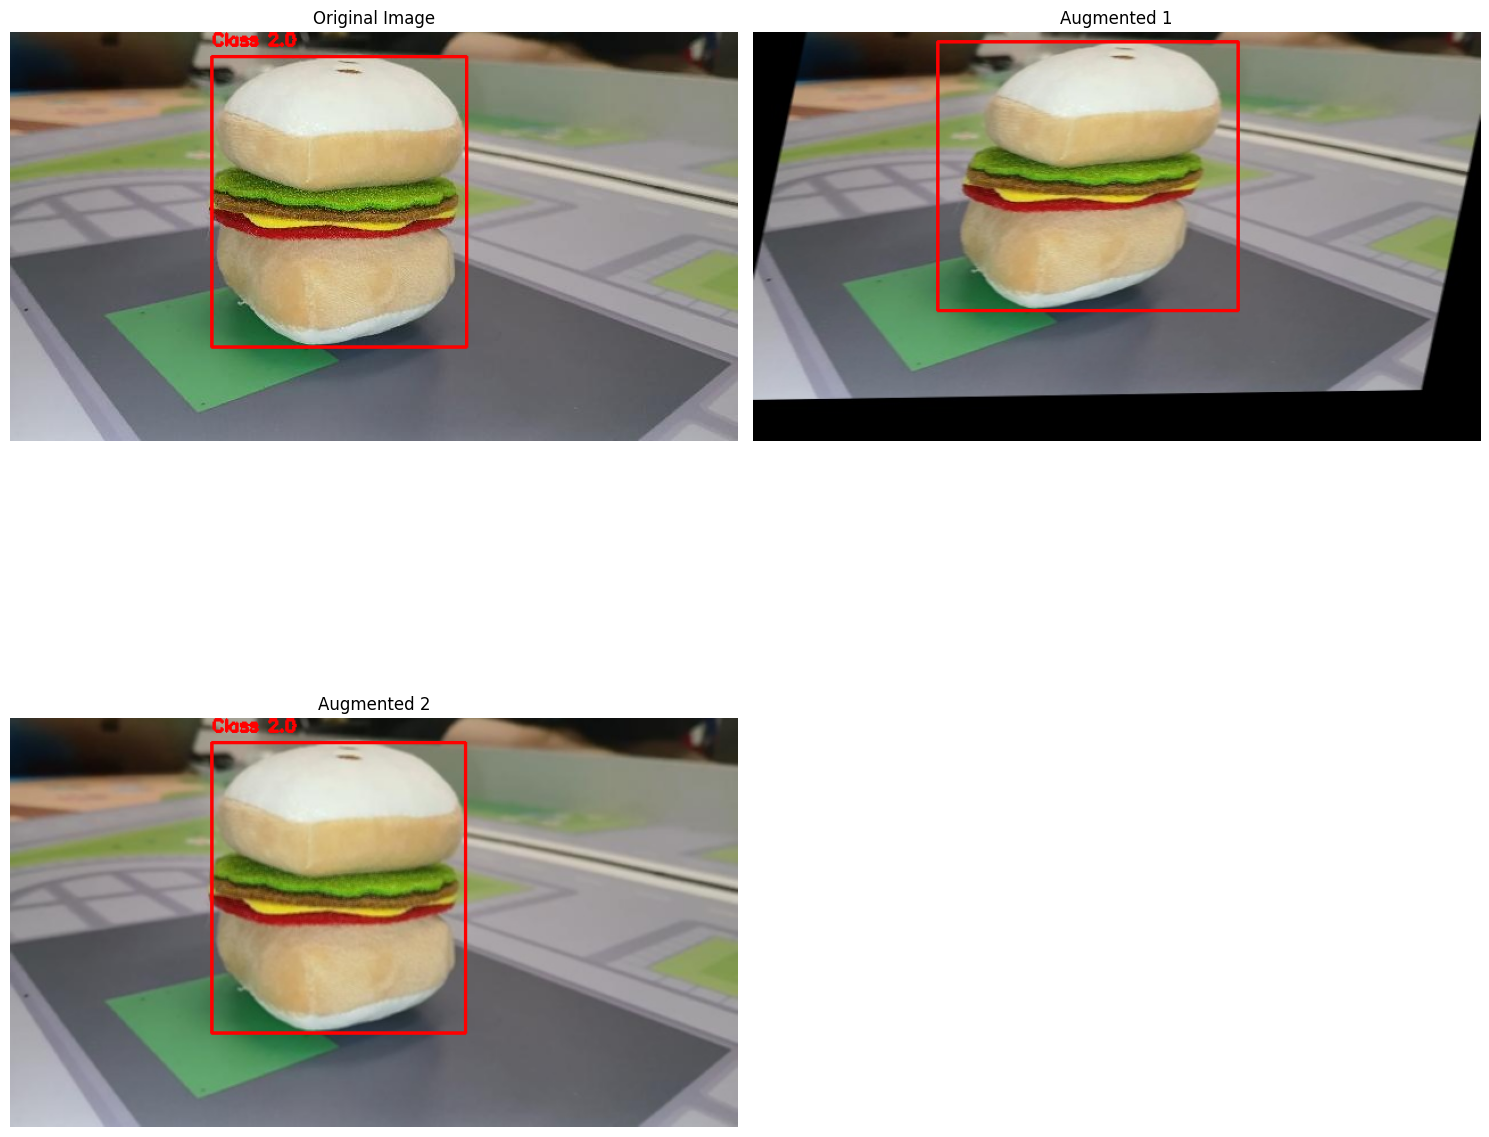

In [63]:
# Read the combined annotations
annotations_df = pd.read_csv('Dataset/annotations_with_augmentation.csv')

original_image_path = "Images/1_png.rf.0b5c1e02611490da804c7014e03fe610.jpg"  # Replace with actual image path
visualize_augmented_images(original_image_path, annotations_df)

In [2]:
def split_dataset(csv_path, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_state=2025):
    """
    Split the dataset into train, validation and test sets while maintaining class balance
    
    Args:
        csv_path: Path to the annotations CSV file
        train_ratio: Ratio of training data (default: 0.7)
        val_ratio: Ratio of validation data (default: 0.15)
        test_ratio: Ratio of test data (default: 0.15)
        random_state: Random seed for reproducibility
    """
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Create separate dataframes for each class
    nothing_samples = df[df['class'] == 0]
    burger_samples = df[df['class'] == 1]
    sandwich_samples = df[df['class'] == 2]
    hotdog_samples = df[df['class'] == 3]
    
    print(f"Total samples: {len(df)}")
    print(f"Nothing samples (class 0): {len(nothing_samples)}")
    print(f"Burger samples (class 1): {len(burger_samples)}")
    print(f"Sandwich samples (class 2): {len(sandwich_samples)}")
    print(f"Hotdog samples (class 3): {len(hotdog_samples)}")
    
    # First split: separate test set for each class
    nothing_train_val, nothing_test = train_test_split(
        nothing_samples, 
        test_size=test_ratio, 
        random_state=random_state
    )
    
    burger_train_val, burger_test = train_test_split(
        burger_samples, 
        test_size=test_ratio, 
        random_state=random_state
    )
    
    sandwich_train_val, sandwich_test = train_test_split(
        sandwich_samples, 
        test_size=test_ratio, 
        random_state=random_state
    )
    
    hotdog_train_val, hotdog_test = train_test_split(
        hotdog_samples, 
        test_size=test_ratio, 
        random_state=random_state
    )
    
    # Second split: separate train and validation from the remaining data
    val_ratio_adjusted = val_ratio / (train_ratio + val_ratio)
    
    nothing_train, nothing_val = train_test_split(
        nothing_train_val, 
        test_size=val_ratio_adjusted, 
        random_state=random_state
    )
    
    burger_train, burger_val = train_test_split(
        burger_train_val, 
        test_size=val_ratio_adjusted, 
        random_state=random_state
    )
    
    sandwich_train, sandwich_val = train_test_split(
        sandwich_train_val, 
        test_size=val_ratio_adjusted, 
        random_state=random_state
    )
    
    hotdog_train, hotdog_val = train_test_split(
        hotdog_train_val, 
        test_size=val_ratio_adjusted, 
        random_state=random_state
    )
    
    # Combine samples for each set
    train_df = pd.concat([nothing_train, burger_train, sandwich_train, hotdog_train])
    val_df = pd.concat([nothing_val, burger_val, sandwich_val, hotdog_val])
    test_df = pd.concat([nothing_test, burger_test, sandwich_test, hotdog_test])
    
    # Shuffle each dataset
    train_df = train_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    val_df = val_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    test_df = test_df.sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    # Print statistics
    print("\nDataset split statistics:")
    print(f"Training set: {len(train_df)} samples")
    print(f"  - Nothing (class 0): {len(train_df[train_df['class'] == 0])}")
    print(f"  - Burger (class 1): {len(train_df[train_df['class'] == 1])}")
    print(f"  - Sandwich (class 2): {len(train_df[train_df['class'] == 2])}")
    print(f"  - Hotdog (class 3): {len(train_df[train_df['class'] == 3])}")
    
    print(f"\nValidation set: {len(val_df)} samples")
    print(f"  - Nothing (class 0): {len(val_df[val_df['class'] == 0])}")
    print(f"  - Burger (class 1): {len(val_df[val_df['class'] == 1])}")
    print(f"  - Sandwich (class 2): {len(val_df[val_df['class'] == 2])}")
    print(f"  - Hotdog (class 3): {len(val_df[val_df['class'] == 3])}")
    
    print(f"\nTest set: {len(test_df)} samples")
    print(f"  - Nothing (class 0): {len(test_df[test_df['class'] == 0])}")
    print(f"  - Burger (class 1): {len(test_df[test_df['class'] == 1])}")
    print(f"  - Sandwich (class 2): {len(test_df[test_df['class'] == 2])}")
    print(f"  - Hotdog (class 3): {len(test_df[test_df['class'] == 3])}")
    
    # Save the splits to CSV files
    train_df.to_csv('Dataset/train.csv', index=False)
    val_df.to_csv('Dataset/val.csv', index=False)
    test_df.to_csv('Dataset/test.csv', index=False)
    
    return train_df, val_df, test_df

In [3]:
train_df, val_df, test_df = split_dataset('Dataset/annotations_with_augmentation.csv')

Total samples: 26869
Nothing samples (class 0): 3968
Burger samples (class 1): 5883
Sandwich samples (class 2): 7110
Hotdog samples (class 3): 9908

Dataset split statistics:
Training set: 18803 samples
  - Nothing (class 0): 2776
  - Burger (class 1): 4117
  - Sandwich (class 2): 4976
  - Hotdog (class 3): 6934

Validation set: 4033 samples
  - Nothing (class 0): 596
  - Burger (class 1): 883
  - Sandwich (class 2): 1067
  - Hotdog (class 3): 1487

Test set: 4033 samples
  - Nothing (class 0): 596
  - Burger (class 1): 883
  - Sandwich (class 2): 1067
  - Hotdog (class 3): 1487


In [11]:
TRAIN_CSV_FILE = 'Dataset/train.csv'
VAL_CSV_FILE = 'Dataset/val.csv'
TEST_CSV_FILE = 'Dataset/test.csv'
IMAGE_DIR = ['Images/', 'Augmented_Images/']

def prepare_dataset(annotations_file, image_dirs=['Images/', 'Augmented_Images/'], target_size=(360, 640), batch_size=64):
    """
    Memory-efficient dataset preparation using tf.data.Dataset
    """
    # Read annotations
    df = pd.read_csv(annotations_file)
    
    def load_image_and_labels(filename, class_label, xmin, ymin, xmax, ymax):
        # Convert filename tensor to string
        fname = filename.numpy().decode('utf-8')
        
        # Try to find the image in any of the provided directories
        image_path = None
        for dir_path in image_dirs:
            temp_path = os.path.join(dir_path, fname)
            if os.path.exists(temp_path):
                image_path = temp_path
                break
        
        if image_path is None:
            print(f"Warning: Image {fname} not found in any of the specified directories")
            # Return zero tensors with correct shapes
            return (
                tf.zeros(target_size + (3,), dtype=tf.float32),
                tf.zeros((4,), dtype=tf.float32),
                tf.zeros((4,), dtype=tf.float32)
            )
        
        # Load and preprocess image
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, target_size)
        img = tf.cast(img, tf.float32) / 255.0
        
        # Create bounding box tensor
        bbox = tf.stack([
            tf.cast(xmin, tf.float32) / tf.cast(target_size[1], tf.float32),
            tf.cast(ymin, tf.float32) / tf.cast(target_size[0], tf.float32),
            tf.cast(xmax, tf.float32) / tf.cast(target_size[1], tf.float32),
            tf.cast(ymax, tf.float32) / tf.cast(target_size[0], tf.float32)
        ])
        
        # Create one-hot encoded class label
        label = tf.one_hot(tf.cast(class_label, tf.int32), depth=4)
        
        return img, label, bbox

    # Create dataset from the dataframe
    dataset = tf.data.Dataset.from_tensor_slices((
        df['filename'].values,
        df['class'].values,
        df['xmin'].values,
        df['ymin'].values,
        df['xmax'].values,
        df['ymax'].values
    ))
    
    # Map the loading function
    dataset = dataset.map(
        lambda f, c, xmin, ymin, xmax, ymax: tf.py_function(
            load_image_and_labels,
            [f, c, xmin, ymin, xmax, ymax],
            [tf.float32, tf.float32, tf.float32]
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Set the shapes explicitly
    dataset = dataset.map(
        lambda img, label, bbox: (
            tf.ensure_shape(img, target_size + (3,)),
            (tf.ensure_shape(label, (4,)), tf.ensure_shape(bbox, (4,)))  # Changed to tuple instead of dict
        )
    )
    
    # Cache, shuffle, batch, and prefetch
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Prepare train, validation and test sets
print("Preparing training data...")
train_dataset = prepare_dataset(TRAIN_CSV_FILE)

print("Preparing validation data...")
val_dataset = prepare_dataset(VAL_CSV_FILE)

print("Preparing test data...")
test_dataset = prepare_dataset(TEST_CSV_FILE)

# Print dataset information
for images, targets in train_dataset.take(1):
    print("\nDataset shapes:")
    print(f"Training batch images: {images.shape}")
    print(f"Training batch class labels: {targets[0].shape}")
    print(f"Training batch bbox targets: {targets[1].shape}")

Preparing training data...


TypeError: in user code:

    File "C:\Users\Admin\AppData\Local\Temp\ipykernel_17020\3585827874.py", line 64, in None  *
        )

    TypeError: Cannot convert the argument `type_value`: {'class_output': tf.float32, 'bbox_output': tf.float32} to a TensorFlow DType.


In [7]:
def create_model(input_shape=(360, 640, 3), num_classes=4):
    # Input layer
    inputs = tf.keras.layers.Input(shape=input_shape, name='input_image')

    base_model = MobileNetV3Large(
        input_shape=(360,640,3),
        include_top=False, 
        weights='imagenet'
    )
    base_model.trainable = True

    x = base_model.output

    x = tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    ########## block 1 ##########
    x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x_shortcut = x

    for i in range(2):
        x = tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x_shortcut = x


    ########## block 2 ##########
    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x_shortcut = x

    for i in range(2):
        x = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x_shortcut = x

    ########## block 3 ##########
    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x_shortcut = x

    for i in range(2):
        x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x_shortcut = x

        
    ########## block 4 ##########
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x_shortcut = x

    for i in range(3):
        x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x_shortcut = x

    ########## block 5 ##########
    x = tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x_shortcut = x

    for i in range(5):
        x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x = tf.keras.layers.Add()([x_shortcut, x])
        x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

        x_shortcut = x

    ########## output layers ##########
    x = tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # Classification head
    class_branch = tf.keras.layers.GlobalAveragePooling2D()(x)
    class_branch = tf.keras.layers.Dense(32, activation='relu')(class_branch)
    class_output = tf.keras.layers.Dense(num_classes, activation='softmax', name='class_output')(class_branch)

    # Bounding box head
    bbox_branch = tf.keras.layers.GlobalAveragePooling2D()(x)
    bbox_branch = tf.keras.layers.Dense(32, activation='relu')(bbox_branch)
    bbox_output = tf.keras.layers.Dense(4, activation='sigmoid', name='bbox_output')(bbox_branch)

    # Create model
    model = tf.keras.Model(
        inputs=inputs,
        outputs=[class_output, bbox_output]
    )
    
    return model

model = create_model()

In [ ]:
# Define optimizer with learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss={
        'class_output': 'categorical_crossentropy',
        'bbox_output': 'mse'
    },
    loss_weights={
        'class_output': 1.0,
        'bbox_output': 1.0
    },
    metrics={
        'class_output': 'accuracy',
        'bbox_output': 'mse'
    }
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 360, 640,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 360, 640,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 180, 320,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 180, 320,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 180, 320,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 180, 320,  │        144 │ activation_20[0]… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 180, 320,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 180, 320,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 180, 320,  │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 180, 320,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 180, 320,  │          0 │ activation_20[0]… │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 180, 320,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 180, 320,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 180, 320,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 181, 321,  │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 90, 160,   │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 90, 160,   │        256 │ expanded_conv_1_

 Total params: 20,247,256 (77.24 MB)

 Trainable params: 20,208,616 (77.09 MB)

 Non-trainable params: 38,640 (150.94 KB)

In [9]:
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            save_best_only=True,
            monitor='val_loss',
            mode='min',
            verbose=1
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            restore_best_weights=True
        )
    ]

history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=32,
        callbacks=callbacks,
        verbose=1
    )

model.save('my_model.keras')

Epoch 1/32


KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m2493236630672\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(None, 360, 640, 3), dtype=float32)\n  • training=True\n  • mask=None'

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['class_output_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_class_output_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on test dataset
print("\nEvaluating on test dataset:")
test_results = model.evaluate(test_dataset, verbose=1)
print("\nTest Results:")
for metric_name, value in zip(model.metrics_names, test_results):
    print(f"{metric_name}: {value:.4f}")

In [ ]:
test_img = 'Images/448_png.rf.c0d24997b23fb6a4844cc647456b99d0.jpg'
model = create_model()
model.load_weights('best_model.h5')

img = keras.preprocessing.image.load_img(test_img, target_size=(360, 640))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
print(predictions)

In [ ]:
bbox = predictions["bbox_output"]
bbox = [bbox[0][0] * 640, bbox[0][1] * 360, bbox[0][2] * 640, bbox[0][3] * 360]
print(bbox)

score = predictions["class_output"]
score = tf.nn.softmax(score)
print(score)
# class_prediction_value = round(predictions["class_output"][0][0])

# classes = ["nothing", "burger"]
# print("Predicted class: {}".format(classes[class_prediction_value]))

In [13]:
testing = keras.preprocessing.image.load_img(test_img, target_size=(360, 640))

img_width, img_height = testing.size
x1 = int(bbox[0])
y1 = int(bbox[1])
x2 = int(bbox[2])
y2 = int(bbox[3])

draw1 = Draw(testing)
bbox_pixels = [(x1, y1), (x2, y2)]
draw1.rectangle(bbox_pixels, outline='red', width=3)
testing.show()

In [ ]:
cam = cv2.VideoCapture(1) 
cam.set(cv2.CAP_PROP_FPS, 120)

while True:
    ret, frame = cam.read()

    frame_resized = cv2.resize(frame, (640, 360))
    frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)

    img_array = tf.expand_dims(frame_rgb, 0)

    predictions = model.predict(img_array, verbose=0)

    bbox = predictions["bbox_output"]
    bbox = [bbox[0][0] * 640, bbox[0][1] * 360, bbox[0][2] * 640, bbox[0][3] * 360]

    class_prediction_value = round(predictions["class_output"][0][0])
    class_name = classes[class_prediction_value]
    print(class_name)

    if class_name != "nothing":
        x1, y1, x2, y2 = int(bbox[0]), int(bbox[1]), int(bbox[2]), int(bbox[3])
        cv2.rectangle(frame_resized, (x1, y1), (x2, y2), (0, 0, 255), 2)
        cv2.putText(frame_resized, class_name, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    cv2.imshow('Camera Feed', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cam.release()
cv2.destroyAllWindows()